In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation,Concatenate
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)



In [3]:
Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

815


In [4]:
for i in range(len(Image_RGB)):
    Image_RGB[i,:,:,:] =  (Image_RGB[i,:,:,:]-np.min( Image_RGB[i,:,:,:]))/(np.max(Image_RGB[i,:,:,:])- np.min(Image_RGB[i,:,:,:]))
#Image_RGB = Image_RGB
Image_RGB = np.ones_like(Image_RGB) - Image_RGB
Image_RGB -= np.mean(Image_RGB)

In [5]:
np.min(Image_RGB)

-0.20112363326323038

In [6]:
np.max(Image_RGB)

0.79887636673676965

In [7]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB

train_data = data
train_label = label
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)
index = [i for i in range(len(train_data))]
#random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]
print('total ',train_data.shape[0], ' samples')

train_data.shape: (14142, 64, 64, 3)
train_label.shape: (14142, 3)
total  14142  samples


In [38]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 600
#intermediate_dim_2 = 300
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)
input_img = Input(shape=(64,64,3))

conv_1 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation=LRelu)(visual)
#h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#h_3 = Dense(intermediate_dim_2,activation='tanh')(z)
h_4 = Dense(intermediate_dim_1,activation='relu')(z)
h_5 = Dense(80*2*2,activation='relu')(h_4)
h_6 = Reshape((2,2,80))(h_5)


conv_6 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_6)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='relu',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(1)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 1*kl_loss_d1 


vae = Model(inputs=input_img, outputs=decoded) 
vae.compile(optimizer='rmsprop', loss=vae_loss) 



In [22]:
#kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-1)*(K.exp(z_log_var/2)+1))/(K.constant(2)),axis = -1)



In [41]:
vae.fit(train_data[:8000], train_data[:8000],  
        shuffle=True,  
        epochs=20,    
        batch_size=batch_size,  
        validation_data=(train_data[8000:9500],train_data[8000:9500]),callbacks=[EarlyStopping])  

Train on 8000 samples, validate on 1500 samples
Epoch 1/20
8000/8000 [==============================] - 21s - loss: -2912.7465 - val_loss: -2707.4467
Epoch 2/20
8000/8000 [==============================] - 21s - loss: -2951.8435 - val_loss: -2752.8824
Epoch 3/20
8000/8000 [==============================] - 21s - loss: -2983.8113 - val_loss: -2795.3254
Epoch 4/20
8000/8000 [==============================] - 21s - loss: -2994.5594 - val_loss: -2798.3785
Epoch 5/20
8000/8000 [==============================] - 22s - loss: -3004.0576 - val_loss: -2781.9512
Epoch 6/20
8000/8000 [==============================] - 21s - loss: -3006.9807 - val_loss: -2822.1848
Epoch 7/20
8000/8000 [==============================] - 21s - loss: -3015.4400 - val_loss: -2779.8155
Epoch 8/20
8000/8000 [==============================] - 21s - loss: -3017.2878 - val_loss: -2813.4536
Epoch 9/20
8000/8000 [==============================] - 21s - loss: -3019.6896 - val_loss: -2832.2240
Epoch 10/20
8000/8000 [===========

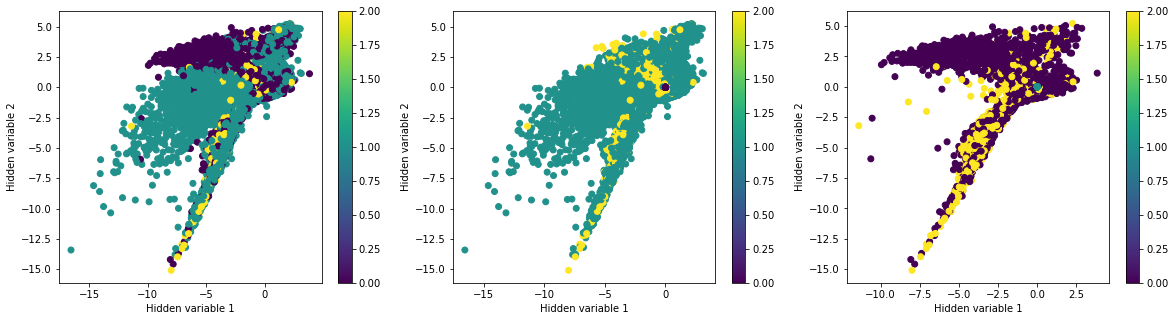

In [42]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

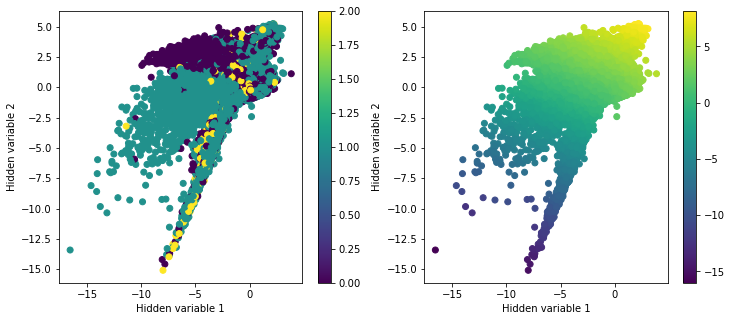

In [43]:
lower_lim = 0
upper_lim = 14000


vis = Model(input_img, z_mean)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

25000


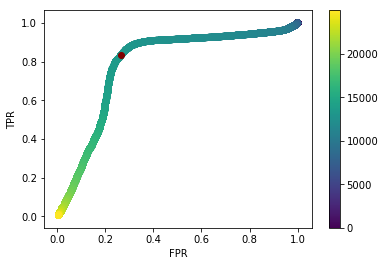

In [46]:
#Y_pred = -Y_pred
thr_min = -15
thr_max = 10
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

In [47]:

from sklearn import metrics
print("AUC:",metrics.auc(FPR, TPR))

AUC: 0.779098238275


In [47]:
batch_size =100
latent_dim = 1
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 600
#intermediate_dim_2 = 300
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)
input_img = Input(shape=(64,64,3))

conv_1 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation=LRelu)(visual)
#h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)
z_mean_2 = Dense(latent_dim)(h_1)
z_log_var_2 = Dense(latent_dim)(h_1)
z_mean_con = Concatenate()([z_mean,z_mean_2])
def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
z_2 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_2, z_log_var_2])

z_combine = Concatenate()([z,z_2])
h_4 = Dense(intermediate_dim_1,activation=LRelu)(z_combine)
h_5 = Dense(80*2*2,activation=LRelu)(h_4)
h_6 = Reshape((2,2,80))(h_5)


conv_6 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(h_6)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation=LRelu,padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    #kl_loss_d2 = - 0.5 * K.sum(1 + z_log_var_2 - K.square(z_mean_2) - K.exp(z_log_var_2), axis=-1) 
    m = K.constant(0)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    m_2 = K.constant(0)
    s_2 = K.constant(1)
    kl_loss_d2 = K.sum(K.log(2*s_2/K.exp(z_log_var_2/2))+(K.constant(2)*m_2*(-K.exp(-(K.square(z_mean_2))/((K.constant(2))*K.exp(z_log_var_2)))*K.exp(z_log_var_2/2) + K.sqrt(K.constant(np.pi/2))*z_mean_2*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean_2/K.constant(np.sqrt(2))/K.exp(z_log_var_2/2)))) )/(K.square(s_2))+(K.square(m_2-z_mean_2)+(K.exp(z_log_var_2/2)-s_2)*(K.exp(z_log_var_2/2)+s_2))/(K.constant(2)*K.square(s_2)),axis = -1)
    return 1*xent_loss + 1*kl_loss_d1 + 1*kl_loss_d2


vae = Model(inputs=input_img, outputs=decoded) 
vae.compile(optimizer='rmsprop', loss=vae_loss) 



In [48]:
vae.fit(train_data[:8000], train_data[:8000],  
        shuffle=True,  
        epochs=20,    
        batch_size=batch_size,  
        validation_data=(train_data[8000:9500],train_data[8000:9500]),callbacks=[EarlyStopping])  

Train on 8000 samples, validate on 1500 samples
Epoch 1/20
8000/8000 [==============================] - 24s - loss: -1974.5819 - val_loss: -2609.7388
Epoch 2/20
8000/8000 [==============================] - 22s - loss: -2798.6846 - val_loss: -2650.9305
Epoch 3/20
8000/8000 [==============================] - 22s - loss: nan - val_loss: nan
Epoch 4/20
8000/8000 [==============================] - 21s - loss: nan - val_loss: nan
Epoch 5/20
8000/8000 [==============================] - 21s - loss: nan - val_loss: nan
Epoch 6/20
8000/8000 [==============================] - 21s - loss: nan - val_loss: nan
Epoch 7/20
8000/8000 [==============================] - 21s - loss: nan - val_loss: nan


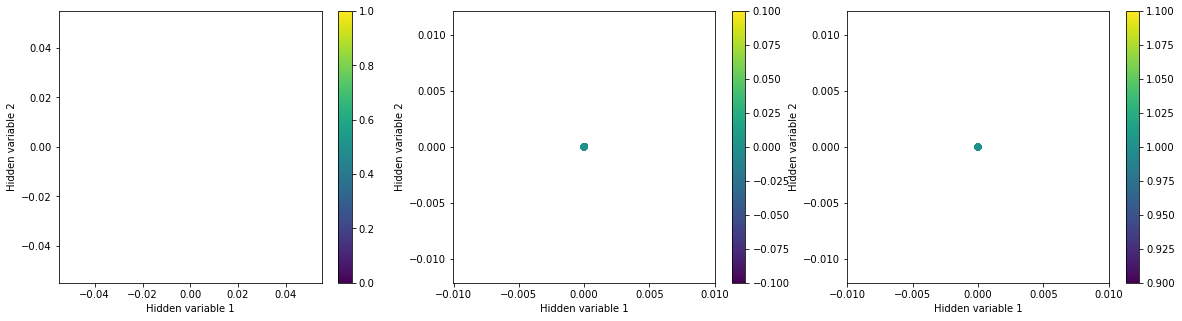

In [49]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean_con)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

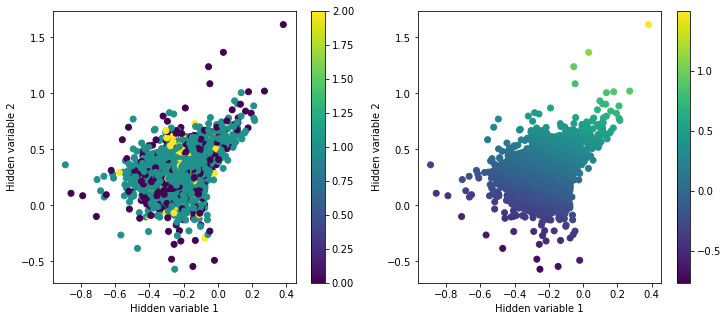

In [33]:
lower_lim = 0
upper_lim = 14000


vis = Model(input_img, z_mean_con)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()